In [23]:
# Importing standard Qiskit libraries:
import numpy as np     
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, assemble
from qiskit.quantum_info import Statevector
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from ibm_quantum_widgets import *
from scipy.linalg import expm

# Loading your IBM Quantum account(s):
#provider = IBMQ.load_account()
large = 40; med = 34; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
plt.rcParams.update(params)

In [24]:
# Number of qubits in the system.
L = 2

In [25]:
def zz_circuit(qubit_0,qubit_1,delta):
    qc_zz = QuantumCircuit(L)
    qc_zz.cx(qubit_0,qubit_1)
    qc_zz.rz(2*delta,qubit_1)
    qc_zz.cx(qubit_0,qubit_1)
    return qc_zz

In [26]:
def xx_circuit(qubit_0,qubit_1,delta):
    qc_xx = QuantumCircuit(L)
    qc_xx.h(qubit_0)
    qc_xx.h(qubit_1)
    qc_xx.cx(qubit_0,qubit_1)
    qc_xx.rz(2*delta,qubit_1)
    qc_xx.cx(qubit_0,qubit_1)
    qc_xx.h(qubit_0)
    qc_xx.h(qubit_1)
    return qc_xx

In [27]:
def yy_circuit(qubit_0,qubit_1,delta):
    qc_yy = QuantumCircuit(L)
    qc_yy.sdg(qubit_0)
    qc_yy.sdg(qubit_1)
    qc_yy.h(qubit_0)
    qc_yy.h(qubit_1)
    qc_yy.cx(qubit_0,qubit_1)
    qc_yy.rz(2*delta,qubit_1)
    qc_yy.cx(qubit_0,qubit_1)
    qc_yy.h(qubit_0)
    qc_yy.h(qubit_1)
    qc_yy.s(qubit_0)
    qc_yy.s(qubit_1)
    return qc_yy

In [42]:
def Z_I_single_qubit_circuit(qubit_0,qubit_1,delta):
    qc_sq = QuantumCircuit(L)
    Z_otimes_I = np.matrix([[1,0,0,0],[0,1,0,0],[0,0,-1,0],[0,0,0,-1]])
    qc_sq.unitary(expm(-1j*Z_otimes_I*(delta)),[qubit_0,qubit_1])
    return qc_sq#.draw("mpl")

def I_Z_single_qubit_circuit(qubit_0,qubit_1,delta):
    qc_sq = QuantumCircuit(L)
    I_otimes_Z = np.matrix([[1,0,0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,-1]])
    qc_sq.unitary(expm(-1j*I_otimes_Z*(delta)),[qubit_0,qubit_1])
    return qc_sq.draw("mpl")

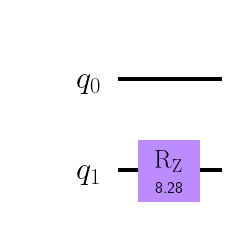

In [51]:
qc = Z_I_single_qubit_circuit(0,1,1)
transpile(qc,basis_gates = ['h','cx','rz'],optimization_level=3).draw("mpl",scale=2)

In [29]:
r"""
The following function constructs the quantum circuit
for one time step for the complete Hamiltonian.
"""
def one_time_step(time_step,h_0,h_1,J):
    
    qr = QuantumRegister(2,"q")
    
    # Create the ancilla register
    #anc = QuantumRegister(1,"ancilla")
    
    # Create the quantum circuit
    qc = QuantumCircuit(qr)
    
    Z_otimes_I = np.matrix([[1,0,0,0],[0,1,0,0],[0,0,-1,0],[0,0,0,-1]])
    qc.unitary(expm(-1j*Z_otimes_I*(h_0*time_step)),[0,1])
    
    I_otimes_Z = np.matrix([[1,0,0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,-1]])
    qc.unitary(expm(-1j*I_otimes_Z*(h_1*time_step)),[0,1])    
    
    qc = qc.compose(xx_circuit(0,1,J*time_step))
    qc = qc.compose(yy_circuit(0,1,J*time_step))
    qc = qc.compose(zz_circuit(0,1,J*time_step))
    
    #qc = qc.compose(xx_circuit(0,1,J*time_step))
    #qc = qc.compose(yy_circuit(0,1,J*time_step))    
    #qc = qc.compose(zz_circuit(0,1,J*time_step))    
    
    
    r"""
    # Odd bonds are constructed.
    for i in range(0,L-1,2):
        qc = qc.compose(xx_circuit(i,i+1,time_step))"""
    
    r"""
    qc.barrier()
    for i in range(0,L-1,2):
        qc = qc.compose(yy_circuit(i,i+1,time_step))"""
        
    #qc.barrier()
    #for i in range(0,L-1,2):
        #qc = qc.compose(zz_circuit(i,i+1,time_step))  
    
        
    r"""
    qc.barrier()
    # Even bonds are constructed.
    for i in range(1,L-1,2):
        qc = qc.compose(xx_circuit(i,i+1,time_step))  
    
    qc.barrier()
    for i in range(1,L-1,2):
        qc = qc.compose(yy_circuit(i,i+1,time_step)) 
        
    qc.barrier()
    for i in range(1,L-1,2):
        qc = qc.compose(zz_circuit(i,i+1,time_step))"""
    
    return qc#.draw("mpl",scale=1.5)   
#one_time_step(1.e-5,0.1,0.2,1).draw("mpl",scale=1.5)

In [30]:
def complete_time_evolution_circuit(time_step,duration,h_0,h_1,J):
    steps = int(duration/time_step)
    qr = QuantumRegister(L,"q")
    
    # Create the ancilla register
    #anc = QuantumRegister(1,"ancilla")
    
    # Create a classical register for classical bits
    classical_register = ClassicalRegister(2,"c")
    # Create the quantum circuit
    qc = QuantumCircuit(qr, classical_register)
    
    # Initialize the qubit here.
    qc.initialize([1,0],0)
    qc.initialize([0,1],1)
    
    for i in range(steps):
        qc = qc.compose(one_time_step(time_step,h_0,h_1,J))
        #qc.rz(2*time_step,0)
        #qc.rz(2*time_step,1)
    #qc.h(1)
    qc.measure(0,0)
    qc.measure(1,1)
    return qc
#J = 1
#delta_t = J/100
#complete_time_evolution_circuit(delta_t,J/100,0.1,-0.1,J).draw("mpl",scale=1.5)

In [31]:
h_0 = 1
h_1 = 1
J = 1

In [32]:
number_of_slots = 1024
r"""
# Evolve the system to the followin total time.
total_time = 5*J

QC = complete_time_evolution_circuit(delta_t,total_time,h_0,h_1,J)
# Simulating the Circuit:
backend = Aer.get_backend('qasm_simulator')
job = execute(QC, backend, shots = number_of_slots)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)""";

In [33]:
wavefunction_00 = []
wavefunction_01 = []
wavefunction_10 = []
wavefunction_11 = []

J = 1
delta_t = J/200

time_lst = np.linspace(0.0001,2,20)

for t in time_lst:
    # Evolve the system to the followin total time.
    total_time = t*J

    QC = complete_time_evolution_circuit(delta_t,total_time,h_0,h_1,J)
    # Simulating the Circuit:
    backend = Aer.get_backend('qasm_simulator')
    job = execute(QC, backend, shots = number_of_slots)
    result = job.result()
    counts = result.get_counts()
    
    try:
        wavefunction_00.append(counts["00"]/number_of_slots)
    except KeyError:
        wavefunction_00.append(0)
        
    try:
        wavefunction_01.append(counts["01"]/number_of_slots)
    except KeyError:
        wavefunction_01.append(0)
        
    try:
        wavefunction_10.append(counts["10"]/number_of_slots)
    except KeyError:
        wavefunction_10.append(0)     
        
    try:
        wavefunction_11.append(counts["11"]/number_of_slots)
    except KeyError:
        wavefunction_11.append(0)

In [34]:
import matplotlib.pyplot as plt

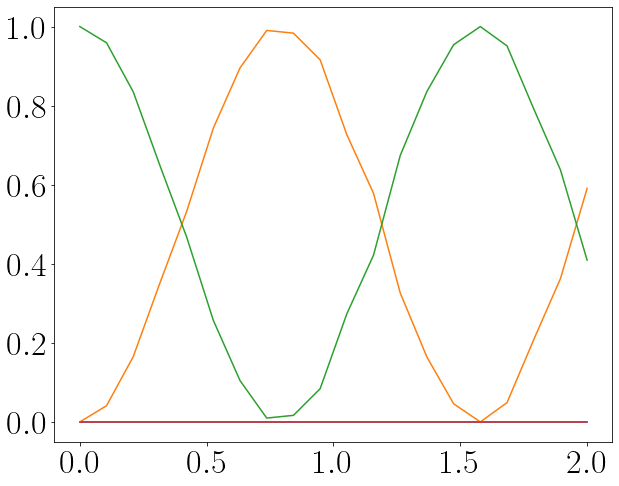

In [36]:
f = plt.figure()
plt.plot(time_lst*J,wavefunction_00)
plt.plot(time_lst*J,wavefunction_01)
plt.plot(time_lst*J,wavefunction_10)
plt.plot(time_lst*J,wavefunction_11)
f.set_figwidth(10)
f.set_figheight(8)
plt.savefig('variation_of_wavefunction_components.jpg', dpi=600)
plt.show()

In [ ]:
#wavefunction_00

# Running on real hardware

In [ ]:
r"""
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)""";

In [ ]:
#import time
#start = time.time()

In [ ]:
r"""
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_circuit = transpile(QC, device, optimization_level=1)
job = device.run(transpiled_circuit)
job_monitor(job, interval=1)""";

In [ ]:
#time_taken = time.time()-start
#print("Time taken = ",time_taken/60,"minutes")

In [ ]:
r"""
# Getting the results from the computation:
results = job.result()
answer = results.get_counts(transpiled_circuit)
plot_histogram(answer)""";

In [ ]:
#answer

# Numerical simulation

In [15]:
import numpy as np
import matplotlib.pyplot as plt
identity_2 = np.matrix([[1,0],[0,1]])
sigma_x    = np.matrix([[0,1],[1,0]])
sigma_y    = np.matrix([[0,-1j],[1j,0]])
sigma_z    = np.matrix([[1,0],[0,-1]])

In [16]:
J     = 1.0
h_lst = [1,1]#2*np.random.rand(2)-1

In [17]:
def Hamiltonian():
    H = np.zeros((4,4))
    # i = 0
    H = H + h_lst[0]*np.kron(sigma_z,identity_2)+J*(np.kron(sigma_x,sigma_x)+np.kron(sigma_y,sigma_y)+np.kron(sigma_z,sigma_z))
    # i = 1
    H = H + h_lst[1]*np.kron(identity_2,sigma_z)#+ J*(np.kron(sigma_x,sigma_x)+np.kron(sigma_y,sigma_y)+np.kron(sigma_z,sigma_z))    
    return H
H = Hamiltonian()

In [18]:
H

matrix([[ 3.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j,  2.+0.j,  0.+0.j],
        [ 0.+0.j,  2.+0.j, -1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]])

In [19]:
from scipy.linalg import expm
def time_evolution(time,initial_state):
    time_evolution_operator = expm(-1j*H*time)
    time_evolved_state = time_evolution_operator@initial_state
    return time_evolved_state

In [20]:
time_evolution(2,np.array([0,0,1,0]))

array([ 0.        +0.j        , -0.68815856-0.31494096j,
        0.27201173-0.59435646j,  0.        +0.j        ])

In [21]:
time_lst = np.linspace(0,2,100)
psi_00 = []
psi_01 = []
psi_10 = []
psi_11 = []
for t in time_lst:
    psi_t = time_evolution(t,np.array([0,0,1,0]))
    psi_00.append(np.abs(psi_t[0])**2)
    psi_01.append(np.abs(psi_t[1])**2)
    psi_10.append(np.abs(psi_t[2])**2)
    psi_11.append(np.abs(psi_t[3])**2)

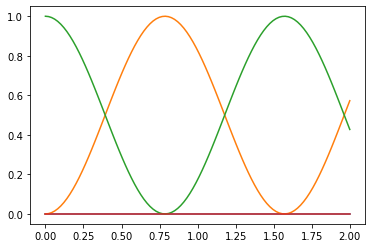

In [22]:
plt.plot(time_lst,psi_00)
plt.plot(time_lst,psi_01)
plt.plot(time_lst,psi_10)
plt.plot(time_lst,psi_11)
plt.show()